In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import src.basic_function_cap as bfc
import src.piano_key_notes as pkn
import src.sheet_reader as sr
import src.hands as h
from tqdm.notebook import tqdm
import ipywidgets as widgets
from ipywidgets import interact

In [2]:
# version
import sys
import matplotlib
import scipy
print(sys.version) # python version
print(cv2.__version__)
print(matplotlib.__version__)
print(np.__version__)
print(scipy.__version__)
print(widgets.__version__)

3.9.7 (v3.9.7:1016ef3790, Aug 30 2021, 16:25:35) 
[Clang 12.0.5 (clang-1205.0.22.11)]
4.6.0
3.5.2
1.23.5
1.8.1
7.7.0


In [3]:
# video
cap = cv2.VideoCapture('mp4/scarborough_fair.mp4')
height, width = 720, 1280

In [4]:
# crops parameters
top_piano, left_piano, height_piano, width_piano = 375, 0, 165, 1280
top_sheet, left_sheet, height_sheet, width_sheet = 8, 158, 332, 960

# some constants
BLUE = [0, 0, 255]
GREEN = [0, 255, 0]
RED = [255, 0, 0]

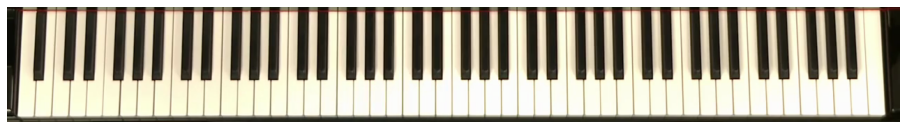

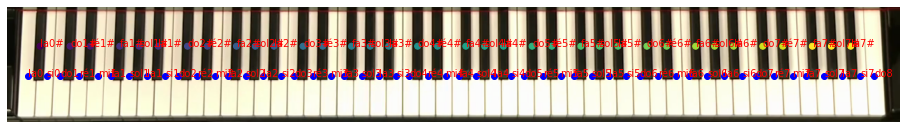

In [5]:
# get labels and notes of piano keys
piano = bfc.get_frame(cap, 814)[1]
piano = bfc.crop_frame(piano, top_piano, left_piano, height_piano, width_piano, show=True, axis=False)
pipe = pkn.pipeline(piano, with_hull=True, threshold = 4000, kx=15, crop=[10,7,15,19], min_area=300, max_width=200, show=[False]*6+[True], axis=False)
labels, black_keys, white_keys, n_labels, stats, centroids, group, notes, sobel = pipe
labels_full = np.zeros((height, width), dtype=np.uint8)
labels_full[top_piano:top_piano+height_piano, left_piano:left_piano+width_piano] = labels
notes_reverse = {v: k for k, v in notes.items()}

In [6]:
# sheet reader
_, frame = bfc.get_frame(cap, 10)
img = bfc.crop_frame(frame, top_sheet, left_sheet, height_sheet, width_sheet, show=False)
_, frame = bfc.get_frame(cap, 781)
img1 = bfc.crop_frame(frame, top_sheet, left_sheet, height_sheet, width_sheet, show=False)
_, frame = bfc.get_frame(cap, 677)
img2 = bfc.crop_frame(frame, top_sheet, left_sheet, height_sheet, width_sheet, show=False)

index_mesures, group_staff, imgs, groups_beat, notes_names, total_beats = sr.pipeline_sheet_reader(img,img1,img2)

[['fa3'], []]


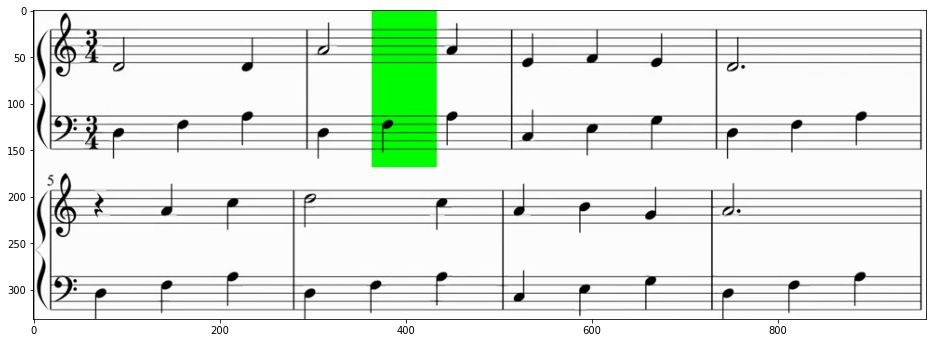

In [7]:
# show beat in sheet
beat = 5
sr.pipeline_beat_reader(beat, index_mesures, group_staff, imgs, groups_beat, notes_names, highlight=True)
notes_at_beat, window = sr.pipeline_beat_reader(beat, index_mesures, group_staff, imgs, groups_beat, notes_names, highlight=False)

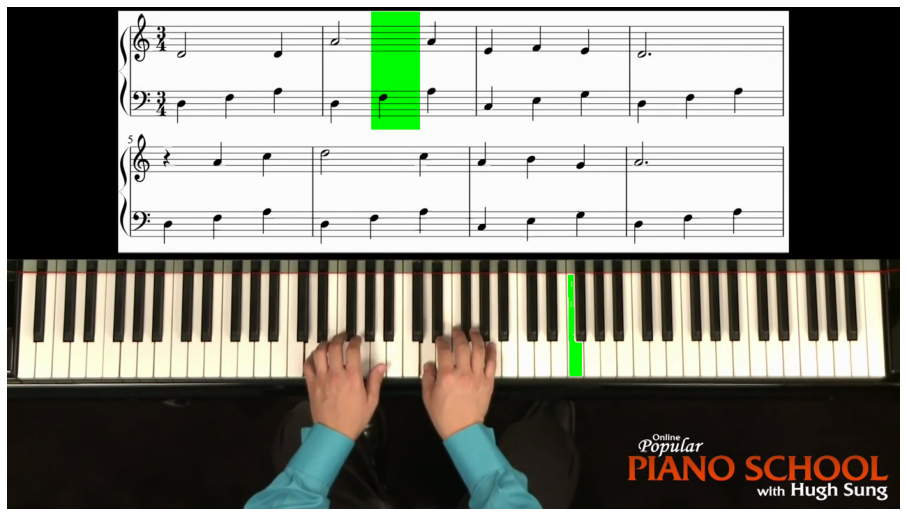

In [8]:
# show beat and piano keys on a video frame

image = bfc.get_frame(cap, 10)[1]

def highlight_beat(image, beat, show=True):
    image = image.copy()
    notes_at_beat, window = sr.pipeline_beat_reader(beat, index_mesures, group_staff, imgs, groups_beat, notes_names, highlight=False)
    x_min, x_max, y_min, y_max = window
    image[y_min+top_sheet:y_max+top_sheet, x_min+left_sheet:x_max+left_sheet, 0] = 0
    image[y_min+top_sheet:y_max+top_sheet, x_min+left_sheet:x_max+left_sheet, 2] = 0
    if show:
        plt.figure(figsize=(16,10))
        plt.imshow(image)
        plt.show()
    return image

def highlight_keys(image, keys:list, color = GREEN, show=True):
    image = image.copy()
    for key in keys:
        image[labels_full == notes_reverse[key]] = color
    if show:
        plt.figure(figsize=(16,10))
        plt.imshow(image)
        plt.axis('off')
        plt.show()
    return image

_ = highlight_keys(highlight_beat(image, 5, False), ['fa5'], GREEN)

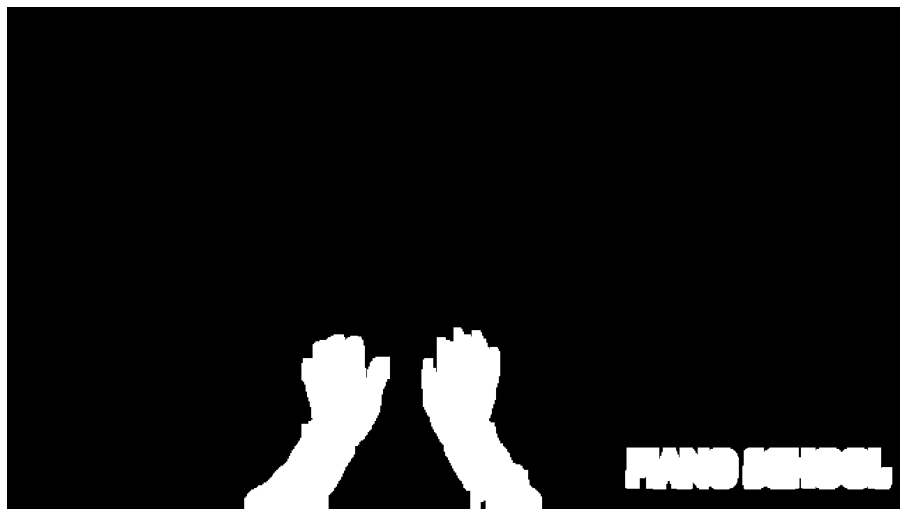

In [9]:
def get_hand_region(frame, threshold=30, show=False):
    new_frame = frame.std(axis=2)
    new_frame[:30,:] = 0
    new_frame[new_frame < threshold] = 0
    new_frame[new_frame >= threshold] = 255
    new_frame[:390,:] = 0
    new_frame = sr.dilate_img(new_frame, kernel_size_x=25, kernel_size_y=10, iterations=1, show = False)
    if show:
        plt.figure(figsize=(16,10))
        plt.imshow(new_frame, cmap='gray')
        plt.axis('off')
        plt.show()
    return new_frame

_ = get_hand_region(image, show=True)

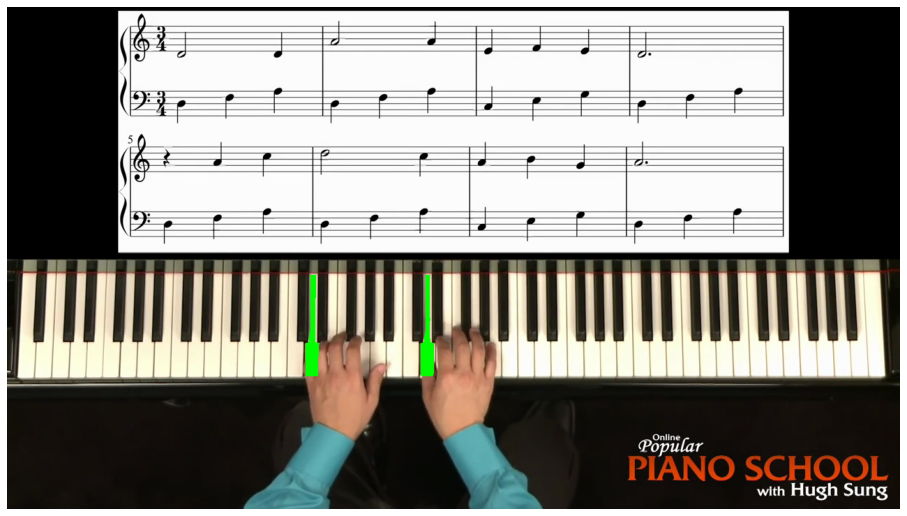

In [10]:
# key pressed

octave = 0
notes12 = ['la','la#','si','do','do#','ré','ré#','mi','fa','fa#','sol','sol#']
name_notes = []
for i in range(88):
    if notes12[i%12] == 'do':
        octave += 1
    if notes12[i%12][-1] == "#":
        name_notes.append(notes12[i%12][:-1]+str(octave)+'#')
    else:
        name_notes.append(notes12[i%12]+str(octave))

def list_key_pressed(frame, shift=0, line=70):
    means = np.load(f'npy/stds_{shift}.npy')
    meansRGB = np.zeros((means.shape[0],means.shape[1]))
    for i in range(means.shape[0]):
        meansRGB[i] = np.mean(means[i], axis=1)
    list_notes = []
    for i in range(20,61):
        if frame > 2 and frame < means.shape[0] - 2:
            if np.mean(np.array([meansRGB[frame + j][i] for j in [-2,-1,0,1,2]])) < line:
                list_notes.append(name_notes[i])
    m = len(list_notes)
    if m > 3:
        list_notes = []
        for i in range(20,61):
            if frame > 2 and frame < means.shape[0] - 2:
                if np.mean(np.array([meansRGB[frame + j][i] for j in [-2,-1,0,1,2]])) < line - (m - 3) * 4:
                    list_notes.append(name_notes[i])
    return list_notes

list_notes = list_key_pressed(frame=10)
plt.figure(figsize=(16,10))
plt.imshow(highlight_keys(image, list_notes, GREEN, False))
plt.axis('off')
plt.show()

In [11]:
# slider

def show_key_beat(frame, beat):
    ret, image = bfc.get_frame(cap, frame)
    if not ret:
        print("Error: frame not found")
        return
    if beat != 0:
        image = highlight_beat(image, beat, False)
        notes_at_beat, window = sr.pipeline_beat_reader(beat, index_mesures, group_staff, imgs, groups_beat, notes_names, highlight=False)
        notes_at_beat_ravel = notes_at_beat[0] + notes_at_beat[1]
        print(notes_at_beat)
        image = highlight_keys(image, notes_at_beat_ravel, RED, False)
    image = highlight_keys(image, list_key_pressed(frame), BLUE, False)
    for note in notes_at_beat_ravel:
        if note in list_key_pressed(frame):
            image[labels_full == notes_reverse[note]] = GREEN
    plt.figure(figsize=(16,10))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

interact(show_key_beat, frame=widgets.IntSlider(min=0, max=int(cap.get(cv2.CAP_PROP_FRAME_COUNT)), step=1, value=186),
                        beat=widgets.IntSlider(min=0, max=total_beats, step=1, value=14))

interactive(children=(IntSlider(value=186, description='frame', max=916), IntSlider(value=14, description='bea…

<function __main__.show_key_beat(frame, beat)>

# Trying to match beat and frame

In [12]:
# First solution to match the beat with the frame is to use the time of the video
# We first find the time of the first beat and the time of the last beat then divide the video in the same number of parts as the number of beats

frame_first_beat = 6
frame_last_beat = 780

def convert_frame_to_beat(frame):
    if frame < frame_first_beat:
        return 0
    elif frame >= frame_last_beat:
        return total_beats
    return int((frame - frame_first_beat) * total_beats / (frame_last_beat - frame_first_beat))+1

# because the pianist doesn't play at constant speed, we use some timestamps
frame_last_beat = 810
dict_beat_frame = {
    1:6,
    22:291,
    38:493,
    54:689,
    57:729,
    58:747,
    59:780,
    60:810,
}

def convert_frame_to_beat(frame):
    if frame < frame_first_beat:
        return 0
    elif frame >= frame_last_beat:
        return total_beats
    beats = [beat for beat in dict_beat_frame]
    for i in range(len(beats)-1):
        if dict_beat_frame[beats[i]] <= frame < dict_beat_frame[beats[i+1]]:
            return int(beats[i] + (frame - dict_beat_frame[beats[i]]) * (beats[i+1] - beats[i]) / (dict_beat_frame[beats[i+1]] - dict_beat_frame[beats[i]]))

In [13]:
def show_key_beat_from_frame(frame):
    ret, image = bfc.get_frame(cap, frame)
    image_copy = image.copy()
    hands = get_hand_region(image_copy)
    beat = convert_frame_to_beat(frame)
    if not ret:
        print("Error: frame not found")
        return
    notes_at_beat_ravel = []
    if beat != 0:
        image = highlight_beat(image, beat, False)
        notes_at_beat, window = sr.pipeline_beat_reader(beat, index_mesures, group_staff, imgs, groups_beat, notes_names, highlight=False)
        notes_at_beat_ravel = notes_at_beat[0] + notes_at_beat[1]
        print(notes_at_beat)
        image = highlight_keys(image, notes_at_beat_ravel, RED, False)
    image = highlight_keys(image, list_key_pressed(frame), BLUE, False)
    for note in notes_at_beat_ravel:
        if note in list_key_pressed(frame):
            image[labels_full == notes_reverse[note]] = GREEN
    image[hands == 255] = image_copy[hands == 255]
    plt.figure(figsize=(16,10))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

interact(show_key_beat_from_frame, frame=widgets.IntSlider(min=0, max=int(cap.get(cv2.CAP_PROP_FRAME_COUNT)), step=1, value=186))

interactive(children=(IntSlider(value=186, description='frame', max=916), Output()), _dom_classes=('widget-int…

<function __main__.show_key_beat_from_frame(frame)>

In [14]:
# save video

def image_key_beat_from_frame(frame):
    ret, image = bfc.get_frame(cap, frame)
    image_copy = image.copy()
    hands = get_hand_region(image_copy)
    beat = convert_frame_to_beat(frame)
    if not ret:
        print("Error: frame not found")
        return
    notes_at_beat_ravel = []
    if beat != 0:
        image = highlight_beat(image, beat, False)
        notes_at_beat, window = sr.pipeline_beat_reader(beat, index_mesures, group_staff, imgs, groups_beat, notes_names, highlight=False)
        notes_at_beat_ravel = notes_at_beat[0] + notes_at_beat[1]
        image = highlight_keys(image, notes_at_beat_ravel, RED, False)
    image = highlight_keys(image, list_key_pressed(frame), BLUE, False)
    for note in notes_at_beat_ravel:
        if note in list_key_pressed(frame):
            image[labels_full == notes_reverse[note]] = GREEN
    image[hands == 255] = image_copy[hands == 255]
    return image

fourcc = cv2.VideoWriter_fourcc(*'h264')
out = cv2.VideoWriter('mp4/output_combine/key_beat_pressed_detection.mp4', # or .mkv
    fourcc, cap.get(cv2.CAP_PROP_FPS),
    (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))))

cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

n = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
for i in tqdm(range(n)):
    ret, _ = cap.read()
    if not ret:
        break
    frame = image_key_beat_from_frame(i)
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    #cv2.putText(frame, str(i), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    out.write(frame)

out.release()
cv2.destroyAllWindows() # Close all windows

OpenCV: FFMPEG: tag 0x34363268/'h264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


  0%|          | 0/916 [00:00<?, ?it/s]

In [15]:
# use ffmpeg to add the audio to the video
#!ffmpeg -i mp4/output_combine/key_beat_pressed_detection.mp4 -i mp4/scarborough_fair.mp4 -c copy -map 0:v:0 -map 1:a:0 mp4/output_combine/key_beat_pressed_detection_with_audio.mp4

In [16]:
# another strategy is that we create a list for each frame
# at each frame, we assign 1 if the key must be pressed, 2 if the key is pressed, 3 if the key is pressed and must be pressed
def get_list_key_pressed(cap):
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    n = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    list_keys_per_frame = []
    for frame in tqdm(range(n)):
        ret, image = cap.read()
        if not ret:
            break
        keyboard = np.array([0] * 88)
        beat = convert_frame_to_beat(frame)
        notes_at_beat_ravel = []
        if beat != 0:
            image = highlight_beat(image, beat, False)
            notes_at_beat, window = sr.pipeline_beat_reader(beat, index_mesures, group_staff, imgs, groups_beat, notes_names, highlight=False)
            notes_at_beat_ravel = notes_at_beat[0] + notes_at_beat[1]
            notes_number = [notes_reverse[note] for note in notes_at_beat_ravel]
            keyboard[notes_number] = 1
        keys_pressed = list_key_pressed(frame)
        keys_number = [notes_reverse[key] for key in keys_pressed]
        keyboard[keys_number] = keyboard[keys_number] + 2
        list_keys_per_frame.append(keyboard)
    return np.array(list_keys_per_frame)

list_keys_per_frame = get_list_key_pressed(cap)

  0%|          | 0/916 [00:00<?, ?it/s]

In [17]:
# now if there is a 3, then we check if there is a 1 or 2 at the frame before (and after)
# if so, we change to 3 and continue until we find a 0 or 3

def refine_list_key_pressed(list_keys_per_frame):
    list_keys_per_frame = list_keys_per_frame.copy()
    for k in range(1, len(list_keys_per_frame)):
        for i in range(88):
            if list_keys_per_frame[k][i] == 3:
                j = k-1
                while j > 0 and 0 < list_keys_per_frame[j][i] < 3:
                    list_keys_per_frame[j][i] = 3
                    j -= 1
                j = k+1
                while j < len(list_keys_per_frame) and 0 < list_keys_per_frame[j][i] < 3:
                    list_keys_per_frame[j][i] = 3
                    j += 1
    return list_keys_per_frame

list_keys_per_frame = refine_list_key_pressed(list_keys_per_frame)

In [18]:
fourcc = cv2.VideoWriter_fourcc(*'h264')
out = cv2.VideoWriter('mp4/output_combine/key_beat_pressed_detection_better.mp4', # or .mkv
    fourcc, cap.get(cv2.CAP_PROP_FPS),
    (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))))

cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

n = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
for i in tqdm(range(n)):
    ret, image = cap.read()
    if not ret:
        break
    image_copy = image.copy()
    hands = get_hand_region(image_copy)
    beat = convert_frame_to_beat(i)
    if 1 <= beat <= 60:
        image = highlight_beat(image, beat, False)
    for j in range(88):
        if list_keys_per_frame[i][j] == 3:
            image[labels_full == j] = GREEN
        elif list_keys_per_frame[i][j] == 2:
            image[labels_full == j] = BLUE
        elif list_keys_per_frame[i][j] == 1:
            image[labels_full == j] = RED
    image[hands == 255] = image_copy[hands == 255]
    #cv2.putText(frame, str(i), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    out.write(image)

out.release()
cv2.destroyAllWindows() # Close all windows

OpenCV: FFMPEG: tag 0x34363268/'h264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


  0%|          | 0/916 [00:00<?, ?it/s]

In [21]:
# use ffmpeg to add the audio to the video
#!ffmpeg -i mp4/output_combine/key_beat_pressed_detection_better.mp4 -i mp4/scarborough_fair.mp4 -c copy -map 0:v:0 -map 1:a:0 mp4/output_combine/key_beat_pressed_detection_better_with_audio.mp4
#!ffmpeg -i mp4/output_combine/key_beat_pressed_detection_better.mp4 -i mp4/scarborough_fair.mp4 -c copy -map 0:v:0 -map 1:a:0 mp4/scarborough_fair_final_output.mp4